# Global fit to all three K2 campaign lightcurves

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
! ls ../data/K2/

S1063_K2_C05_lightkurve_SFF.csv S1063_K2_C18_lightkurve_SFF.csv
S1063_K2_C16_lightkurve_SFF.csv


In [3]:
dfC16 = pd.read_csv('../data/K2/S1063_K2_C16_lightkurve_SFF.csv')
dfC18 = pd.read_csv('../data/K2/S1063_K2_C18_lightkurve_SFF.csv')

In [4]:
df = pd.concat([dfC16, dfC18], ignore_index=True)
df['flux'] = df.flux / np.percentile(df.flux, 98)

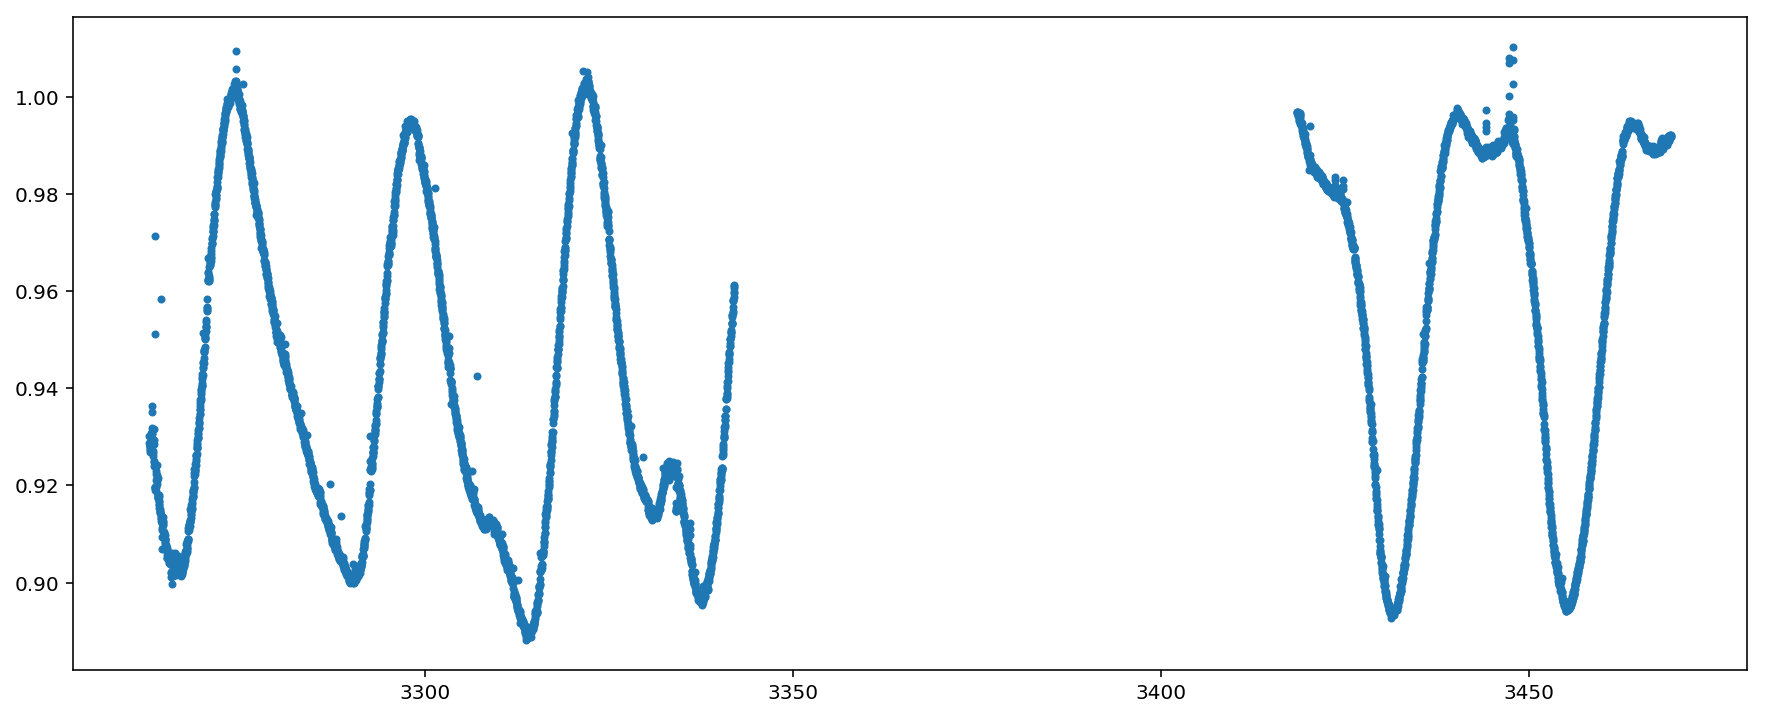

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df.time, df.flux, '.')

In [6]:
df_subset = df

In [7]:
t = df_subset.time.values
y = df_subset.flux
yerr = 0.001 * np.ones(len(t))

<ErrorbarContainer object of 3 artists>

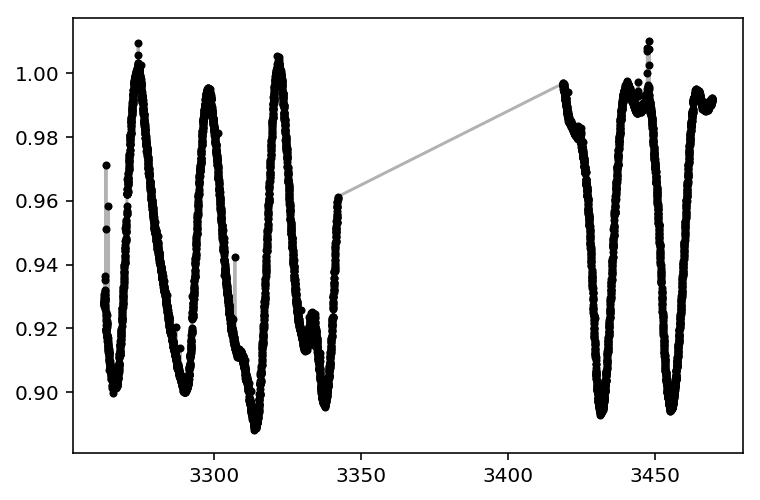

In [8]:
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.99, 1.0)
#plt.xlim(3272, 3273)

<ErrorbarContainer object of 3 artists>

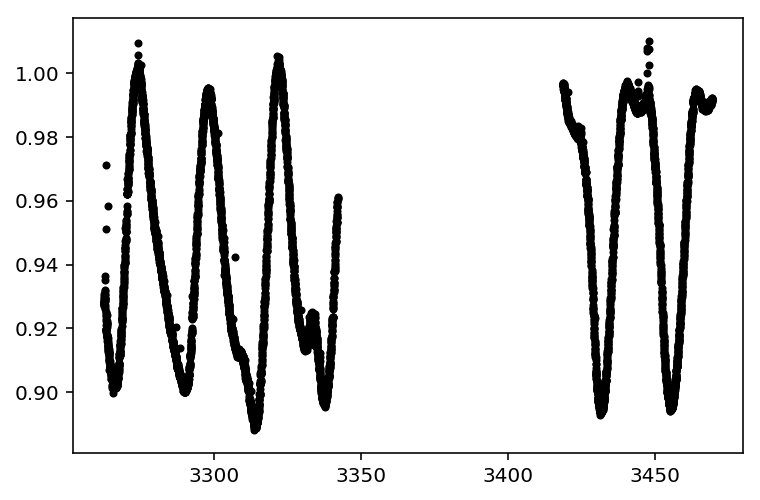

In [9]:
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)

In [10]:
2.0 * np.pi / 23.5

0.26736958753955686

Try design matrix approach

In [11]:
P_fit = 23.67
P_fit2 = 7.48

In [12]:
x = t
x_dense = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/24/2.0)

In [13]:
sin_vector = np.sin(2.0*np.pi*x/P_fit)
cos_vector = np.cos(2.0*np.pi*x/P_fit)
sin_vector2 = np.sin(2.0*np.pi*x/(P_fit2))
cos_vector2 = np.cos(2.0*np.pi*x/(P_fit2))

A = np.concatenate((np.expand_dims(sin_vector, 1),
                    np.expand_dims(cos_vector, 1),
                    np.expand_dims(sin_vector2, 1),
                    np.expand_dims(cos_vector2, 1),
                    np.vander(x, 3)), axis=1)

ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)


A_dense = np.concatenate((np.expand_dims(np.sin(2.0*np.pi*x_dense/P_fit), 1),
                          np.expand_dims(np.cos(2.0*np.pi*x_dense/P_fit), 1),
                          np.expand_dims(np.cos(2.0*np.pi*x_dense/(P_fit2)), 1),
                          np.expand_dims(np.cos(2.0*np.pi*x_dense/(P_fit2)), 1),
                          np.vander(x_dense, 3)), axis=1)

yfit_dense = np.matmul(mean_w, A_dense.T)

In [14]:
df_fit = pd.DataFrame({'time':x_dense, 'flux':yfit_dense})

In [15]:
def compute_ydense(P1, P2):
    sin_vector = np.sin(2.0*np.pi*x/P1)
    cos_vector = np.cos(2.0*np.pi*x/P1)
    sin_vector2 = np.sin(2.0*np.pi*x/(P2))
    cos_vector2 = np.cos(2.0*np.pi*x/(P2))

    A = np.concatenate((np.expand_dims(sin_vector, 1),
                        np.expand_dims(cos_vector, 1),
                        np.expand_dims(sin_vector2, 1),
                        np.expand_dims(cos_vector2, 1),
                        np.vander(x, 3)), axis=1)

    ATA = np.dot(A.T, A / yerr[:, None]**2)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

    yfit = np.matmul(mean_w, A.T)

    A_dense = np.concatenate((np.expand_dims(np.sin(2.0*np.pi*x_dense/P1), 1),
                              np.expand_dims(np.cos(2.0*np.pi*x_dense/P1), 1),
                              np.expand_dims(np.cos(2.0*np.pi*x_dense/(P2)), 1),
                              np.expand_dims(np.cos(2.0*np.pi*x_dense/(P2)), 1),
                              np.vander(x_dense, 3)), axis=1)

    yfit_dense = np.matmul(mean_w, A_dense.T)
    return yfit_dense

In [16]:
def compute_chisq(P1, P2):
    sin_vector = np.sin(2.0*np.pi*x/P1)
    cos_vector = np.cos(2.0*np.pi*x/P1)
    sin_vector2 = np.sin(2.0*np.pi*x/(P2))
    cos_vector2 = np.cos(2.0*np.pi*x/(P2))

    A = np.concatenate((np.expand_dims(sin_vector, 1),
                        np.expand_dims(cos_vector, 1),
                        np.expand_dims(sin_vector2, 1),
                        np.expand_dims(cos_vector2, 1),
                        np.vander(x, 3)), axis=1)

    ATA = np.dot(A.T, A / yerr[:, None]**2)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

    yfit = np.matmul(mean_w, A.T)
    resid_sq = (yfit-y)**2
    return np.sum(resid_sq)

In [17]:
import yaml

from bokeh.layouts import column, widgetbox
from bokeh.models import ColumnDataSource, Slider
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook

from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

output_notebook()

Loading BokehJS ...

In [18]:
slider = Slider(start=0, end=30, value=0, step=1, title="Smoothing by N Days")

In [19]:
source2 = ColumnDataSource(data=df_fit)

In [20]:
def modify_doc(doc):
    source = ColumnDataSource(data=df)
    source2 = ColumnDataSource(data=df_fit)

    plot = figure()
    plot.line('time', 'flux', source=source)
    plot.line('time', 'flux', source=source2, color='red')
    

    def callback(attr, old, new):
        term1 = np.sin(2.0*np.pi*(x_dense - slider3.value)/slider1.value)
        #term2 = np.cos(2.0*np.pi*x_dense/slider1.value)
        #net = slider2.value*term1 + slider3.value*term2 + slider4.value
        net1 = slider2.value*term1 + slider4.value
        
        term2 = np.sin(2.0*np.pi*(x_dense - slider7.value)/slider5.value)
        net2 = slider6.value * term2 
        
        source2.data['flux'] = net1 + net2
        
    def callback2(attr, old, new):
        
        ydense = compute_ydense(slider1.value, slider5.value)
        source2.data['flux'] = ydense
    
    slider1 = Slider(start=22, end=25, value=23.32, step=0.001, title="P1", width=600)
    #slider2 = Slider(start=0, end=0.2, value=0.05, step=0.001, title="A")
    #slider3 = Slider(start=0, end=24, value=1.85, step=0.05, title="Phase")
    #slider4 = Slider(start=0.9, end=1, value=0.95, step=0.001, title="C")
    
    slider5 = Slider(start=11.0, end=14.0, value=12.5, step=0.001, title="P2", width=600)
    #slider6 = Slider(start=0, end=0.2, value=0.01, step=0.001, title="B")
    #slider7 = Slider(start=0, end=24, value=1.85, step=0.05, title="Phase2")
    
    
    slider1.on_change('value', callback2)
    #slider2.on_change('value', callback)
    #slider3.on_change('value', callback)
    #slider4.on_change('value', callback)
    slider5.on_change('value', callback2)
    #slider6.on_change('value', callback)
    #slider7.on_change('value', callback)

    #doc.add_root(column(widgetbox([slider1, slider2, slider3, slider4,slider5, slider6, slider7]), plot))
    doc.add_root(column(widgetbox([slider1, slider5]), plot))

In [21]:
slid = show(modify_doc)

The end!